**Create A VQ-VAE for the CIFAR 10 Dataset**
\\
The main architecture will take the form Encoder -> Vector Quantization -> Decoder.


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from tqdm import tqdm

/home/jason/miniconda3/envs/icvf/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

**Residual Layers For Image Processing.** We use Resnet blocks because why not. A few different things to try are: use VIT blocks?

In [5]:
class ResidualLayerBlock(nn.Module):
  def __init__(self, in_dim, h_dim, res_h_dim):
    super().__init__()
    self.block = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(in_channels=in_dim, out_channels = res_h_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(res_h_dim),
        nn.ReLU(),
        nn.Conv2d(in_channels=res_h_dim, out_channels=h_dim, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(h_dim)
    )

  def forward(self, x):
    out = x + self.block(x)
    return out

In [6]:
class ResidualLayers(nn.Module):
  def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
    super().__init__()
    self.n_res_layers = n_res_layers
    self.layers = nn.ModuleList(
        [ResidualLayerBlock(in_dim, h_dim, res_h_dim)] * n_res_layers
    )

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return F.relu(x)

**The Encoder Class:** encodes the image into a lower resolution

In [7]:
class Encoder(nn.Module):
  def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
    super().__init__()
    kernel = 4
    stride = 2
    #Maybe remove batch norms?
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_dim, h_dim // 2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(h_dim // 2),
        nn.ReLU(),
        nn.Conv2d(h_dim // 2, h_dim, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(h_dim),
        nn.ReLU(),
        nn.Conv2d(h_dim, h_dim, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(h_dim),
        ResidualLayers(h_dim, h_dim, res_h_dim, n_res_layers)
    ) 

  def forward(self, x):
    return self.conv_block(x)

**The Vector Quantitizer Class:** Recall that loss is defined as:
$$Recon(x, \hat{x}) + ||sg(z_e(x)) - e||_2^2 + \beta ||z_e(x) - e||_2^2$$
Where the first term is our codebook loss to keep our codebook close to our encoder outputs, and the third term is keep our codebook committed to a discrete distribution. Note that we are going to be quantizing over each individual channel pixel, so we we sample a channel from the discrete distribution. If the original image size is say for example $[64, 3, 32, 32]$, we first rearrange it to have each element be a channel pixel, i.e $[64, 32, 32, 3]$, then flatten it to get each individuala channel yielding $[64 * 32 * 32, 3]$. Now we have $64 * 32 * 32$ seperate channel pixels to query from the latent distribution, and map them to its closest latent distribution value. It should be noted that the outputs from the gradient wont have any actual gradients, because of the nearest neighbor sampling. To deal with this, we copy the gradient from the outputs to the inputs. In other words, we do:
$$e := z_e(x) + sg(e - z_e(x))$$
This allows the gradients of $e$ to be copied over to $z_e(x)$ and backprop to our encoder.

In [8]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) 
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach() #allows for copied gradients
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices

**The Decoder Class** Uses the sampled discrete distribution and reconstruct the image.

In [9]:
class Decoder(nn.Module):
    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualLayers(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 3, kernel_size=kernel,
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)

**The VQAE Module**: This is the main module for the VQ-VAE. The model consists of 
$$Encoder \to VectorQuantitization \to Decoder \to \hat{x}$$
Each image will have its own discrete mapping. Let $f_{vq}(x)$ be the discrete mapping from an image $x$ to its discrete mapping. Once the model is trained, we will have good mappings for $x \to f_{vq}(x)$. However, to actually sample from the VQ-VAE, we need to learn patterns from the learned $f_{vq}(x)$. Once we can sample $f_{vq}$ perhaps using PixelCNN, we can send it into the decoder.

In [10]:
class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(3, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x, verbose=False):

        z_e = self.encoder(x)

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _, _ = self.vector_quantization(z_e)
        x_hat = self.decoder(z_q)

        return embedding_loss, x_hat, perplexity

In [11]:
training_data = torchvision.datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = torchvision.datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

Files already downloaded and verified
Files already downloaded and verified


In [12]:
data_variance = np.var(training_data.data / 255.0)
data_variance

0.06328692405746414

**Define our Hyperparameters**

In [13]:
bsz = 64
n_hiddens = 128
n_residual_hiddens = 32
n_residual_layers = 2
embedding_dim = 64
n_embeddings = 512
beta = .25
lr = 3e-4
epochs = 20

In [14]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size = bsz, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=32,shuffle=True)

In [15]:
model = VQVAE(n_hiddens, n_residual_hiddens, n_residual_layers,
              n_embeddings, embedding_dim, 
              beta).to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=False)

In [22]:
train_res_recon_error = []
train_res_perplexity = []
for epoch in range(epochs):
  with tqdm(train_loader, unit="batch") as tepoch:
    model.train()
    for data, target in tepoch:
      data = data.to(device)
      optimizer.zero_grad()

      vq_loss, data_recon, perplexity = model(data)
      recon_error = F.mse_loss(data_recon, data) / data_variance
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()
      tepoch.set_postfix(loss=float(loss.detach().cpu()))
      train_res_recon_error.append(recon_error.item())
      train_res_perplexity.append(perplexity.item())
    
  avg_loss = 0
  model.eval()
  for data, target in validation_loader:
    data = data.to(device)

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error.item() * 32

    avg_loss += loss / len(validation_data)
    
  print(f'Validation Loss: {avg_loss}')


100%|██████████| 782/782 [01:01<00:00, 12.81batch/s, loss=2.11]


Validation Loss: 0.5849672517776492


100%|██████████| 782/782 [01:00<00:00, 12.83batch/s, loss=1.39]


Validation Loss: 0.458469847202301


100%|██████████| 782/782 [01:00<00:00, 12.90batch/s, loss=0.874]


Validation Loss: 0.3705719062805173


100%|██████████| 782/782 [01:00<00:00, 12.92batch/s, loss=0.675]


Validation Loss: 0.333509005355835


100%|██████████| 782/782 [00:59<00:00, 13.04batch/s, loss=0.561]


Validation Loss: 0.3168003671646118


100%|██████████| 782/782 [01:00<00:00, 12.87batch/s, loss=0.548]


Validation Loss: 0.28090426774024957


100%|██████████| 782/782 [01:01<00:00, 12.68batch/s, loss=0.494]


Validation Loss: 0.24150701980590822


100%|██████████| 782/782 [01:00<00:00, 12.91batch/s, loss=0.473]


Validation Loss: 0.208188880777359


100%|██████████| 782/782 [01:00<00:00, 12.96batch/s, loss=0.462]


Validation Loss: 0.1989274936676025


100%|██████████| 782/782 [01:00<00:00, 12.96batch/s, loss=0.475]


Validation Loss: 0.17336862273216247


100%|██████████| 782/782 [01:00<00:00, 12.88batch/s, loss=0.385]


Validation Loss: 0.15667821490764625


100%|██████████| 782/782 [01:00<00:00, 12.86batch/s, loss=0.306]


Validation Loss: 0.1401786805868149


100%|██████████| 782/782 [01:00<00:00, 13.03batch/s, loss=0.303]


Validation Loss: 0.15510688357353217


100%|██████████| 782/782 [01:00<00:00, 12.91batch/s, loss=0.261]


Validation Loss: 0.12990169551372524


 58%|█████▊    | 455/782 [00:36<00:29, 11.20batch/s, loss=0.273]

In [ ]:
torch.save(model.state_dict(), f'VQ-VAE_Model_{n_embeddings}embeds')

In [1]:
plt.plot(train_res_recon_error)
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()
#plt.xlabel('Batches')
#plt.ylabel('Training Perplexity')
#plt.plot(perplexity)
#plt.show()

NameError: name 'plt' is not defined

**Reconstruction Quality**

One question of potential interest is: how does the number of embeddings affect the reconstruction quality? It's impractical to train a VQVAE many times, so let's load in some pretrained models and see how the quality changes. Change the number of embeddings to see how the reconstruction quality changes.

In [17]:
n_embeddings = 512
model = VQVAE(n_hiddens, n_residual_hiddens, n_residual_layers,
              n_embeddings, embedding_dim, 
              beta).to(device)
model.load_state_dict(torch.load(f'VQ-VAE_Model_{n_embeddings}embeds'))

<All keys matched successfully>

In [18]:
model.eval()
validation_loader = torch.utils.data.DataLoader(validation_data,batch_size=16,shuffle=True)
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = model(valid_originals)

In [19]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


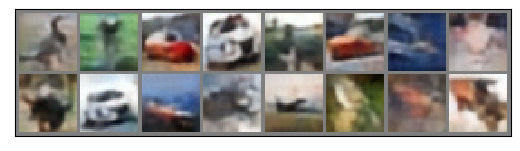

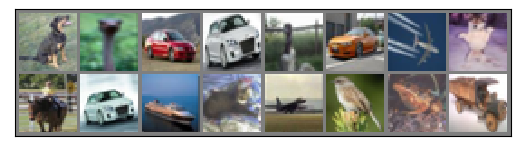

In [20]:
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, )
plt.show()
show(torchvision.utils.make_grid(valid_originals.cpu()) + 0.5, )
plt.show()

**Sampling**

Unlike VAEs, VQ-VAEs can be difficult to sample from. Recall in VAEs, we enforced $p(z) \sim N(0, I)$ using a KL divergence loss. This makes it easy to sample a VAE. But VQ-VAEs don't have this nice property. 

To see this, we can try sampling $z$ uniformly, and see the resulting image. To be more explicit, for each latent pixel in the 8x8 space, we sample one of the 512 codebook vectors uniformly, then feed the whole thing into the decoder.

In [21]:
# first load the model again
n_embeddings = 512
model = VQVAE(n_hiddens, n_residual_hiddens, n_residual_layers,
              n_embeddings, embedding_dim, 
              beta).to(device)
model.load_state_dict(torch.load(f'VQ-VAE_Model_{n_embeddings}embeds'))

<All keys matched successfully>

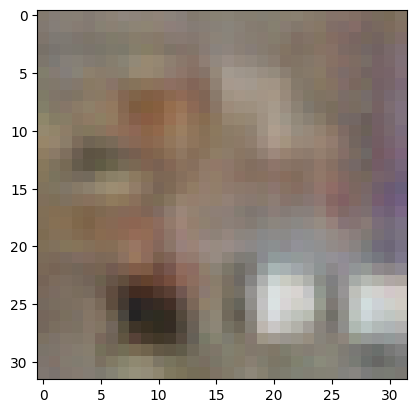

In [128]:
def sample_model_uniform(model):
  # sample 8 x 8 embedding vectors
  encoding_indices = torch.argmin(torch.rand(size = [8 * 8, n_embeddings]), dim=1).to(device).unsqueeze(1)
  encodings = torch.zeros(encoding_indices.shape[0], n_embeddings, device=device)
  encodings.scatter_(1, encoding_indices, 1)
  quantized = torch.matmul(encodings, model.vector_quantization._embedding.weight)
  quantized = quantized.view(1, 8, 8, 64)
  quantized = quantized.permute(0, 3, 1, 2).contiguous()
  z_e = model.decoder(quantized)
  return z_e

plt.imshow(sample_model_uniform(model).squeeze(0).permute(1, 2, 0).cpu().detach() + 0.5)

Chances are the generated image is difficult to recognize. We have 512 codebook vectors, each of which can go into 1 of the squares in the 8 by 8 embedding. So despite being a discrete representation, there are some $64^{512} \approx 10^{900}$ possible things that can be encoded. So it makes sense that sampling uniformly in this space likely won't reveal anything meaningful. 

Run the code below to see an example of the embedding index per latent pixel. Do this a couple times for different images. What do you see, are there patterns you notice?

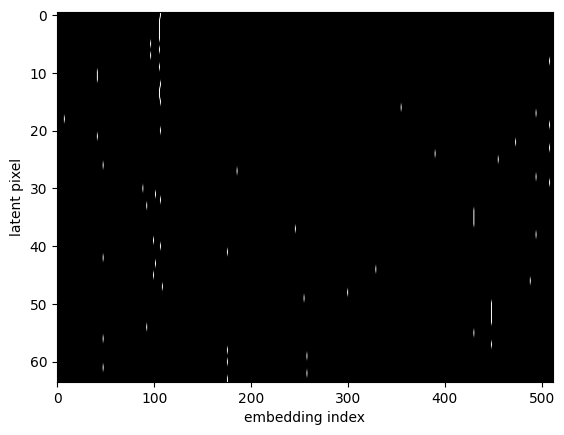

In [23]:
# vqvae latents
viz_loader = torch.utils.data.DataLoader(training_data, batch_size = 1, shuffle = True)
X, _ = next(iter(viz_loader))
X = X.to(device)
z_e = model.encoder(X)
z_e = model.pre_quantization_conv(z_e)
_, z_q, _, encodings, _ = model.vector_quantization(z_e)
plt.imshow(encodings.cpu().numpy(), cmap='gray', aspect='auto')
plt.xlabel('embedding index')
plt.ylabel('latent pixel')
plt.show()

**Train an autoregressive model**

From the visualizations above, it should be relatively clear that the embeddings chosen per pixel are neither uniformly distributed, nor independent. We'd been breaking apart $p(z_1,\ldots, z_n) = \prod_{i=1}^n p(z_i)$. What would make the generation better would be to learn a conditional distribution of each latent pixel based on the previous ones: $p(z_k | z_{k-1} \ldots z_1)$. In the original VQ-VAE paper, this is done using an autoregressive model, PixelCNN. Here, we attempt to do the same thing.

In [97]:
# PixelCNNs aren't the focus of this project.
# This was taken from: https://github.com/jzbontar/pixelcnn-pytorch/

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

fm = 64
pixCNN = nn.Sequential(
    MaskedConv2d('A', 512,  fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    nn.Conv2d(fm, 512, 1)).to(device)

In [98]:
lr = 0.001
batch_size = 128
epochs = 15

optimizer = torch.optim.Adam(pixCNN.parameters(), lr=lr)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

train_losses = []
for _ in range(epochs):
    for X, _ in tqdm(train_loader):
        if X.shape[0] != batch_size:
            continue

        # get our embedding
        X = X.to(device)
        z_e = model.encoder(X)
        z_e = model.pre_quantization_conv(z_e)
        _, z_q, _, encodings, enc_inds = model.vector_quantization(z_e) 

        encodings_img = encodings.reshape(batch_size, 8, 8, -1)
        encodings_img = encodings_img.permute(0, 3, 1, 2).float().to(device)

        # learn
        optimizer.zero_grad()
        output = pixCNN(encodings_img)

        output = output.permute(0, 2, 3, 1)
        output = output.reshape(-1, 512)

        loss = F.cross_entropy(output, enc_inds.squeeze(1).long())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    print(train_losses[-1])

100%|██████████| 391/391 [00:40<00:00,  9.55it/s]


3.0997672080993652


100%|██████████| 391/391 [00:41<00:00,  9.41it/s]


2.9185526371002197


100%|██████████| 391/391 [00:41<00:00,  9.45it/s]


2.830815553665161


100%|██████████| 391/391 [00:41<00:00,  9.43it/s]


2.763129949569702


100%|██████████| 391/391 [00:42<00:00,  9.23it/s]


2.728013277053833


100%|██████████| 391/391 [00:40<00:00,  9.54it/s]


2.7450978755950928


100%|██████████| 391/391 [00:43<00:00,  9.05it/s]


2.6775717735290527


100%|██████████| 391/391 [00:41<00:00,  9.49it/s]


2.796200752258301


100%|██████████| 391/391 [00:42<00:00,  9.19it/s]


2.729017734527588


100%|██████████| 391/391 [00:41<00:00,  9.50it/s]


2.74345064163208


100%|██████████| 391/391 [00:41<00:00,  9.31it/s]


2.7042484283447266


100%|██████████| 391/391 [00:40<00:00,  9.68it/s]


2.6424055099487305


100%|██████████| 391/391 [00:40<00:00,  9.55it/s]


2.664748191833496


100%|██████████| 391/391 [00:40<00:00,  9.57it/s]


2.6444859504699707


100%|██████████| 391/391 [00:40<00:00,  9.57it/s]

2.6502885818481445


In [100]:
torch.save(pixCNN.state_dict(), 'PixCNN.pt')
pixCNN.load_state_dict(torch.load('PixCNN.pt'))

<All keys matched successfully>

/home/jason/miniconda3/envs/icvf/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


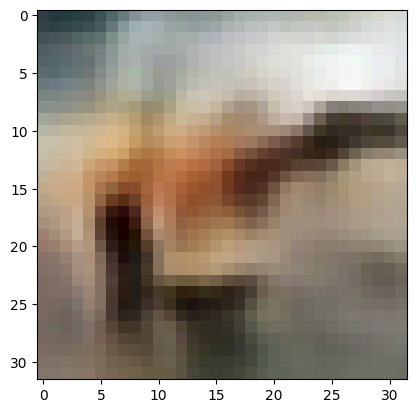

In [137]:
sample = torch.zeros(1, 512, 8, 8).to(device)
for i in range(8):
    for j in range(8):
        output = pixCNN(sample)
        weights = F.softmax(output[:, :, i, j])
        embed_indx = torch.multinomial(weights, 1).item()
        sample[:, embed_indx, i, j] = 1

sample = sample.squeeze(0).reshape(512, 64)
sample = sample.permute((1, 0))

quantized = torch.matmul(sample, model.vector_quantization._embedding.weight)
quantized = quantized.view(1, 8, 8, 64)
quantized = quantized.permute(0, 3, 1, 2).contiguous()
z_e = model.decoder(quantized)

plt.imshow(z_e.squeeze(0).permute(1, 2, 0).cpu().detach() + 0.5)
plt.show()